In [6]:
import math
import heapq
from dataclasses import dataclass, field
from typing import List, Optional, Tuple

# Constants
INF = math.inf
# 8 possible directions (up, down, left, right, and diagonals)
DIRECTIONS = [
    (1, 0),   # Down
    (-1, 0),  # Up
    (0, 1),   # Right
    (0, -1),  # Left
    (1, 1),   # Down-Right
    (-1, 1),  # Up-Right
    (1, -1),  # Down-Left
    (-1, -1)  # Up-Left
]

@dataclass(order=True)
class Point:
    x: int
    y: int

@dataclass
class Room:
    rows: int
    cols: int
    start: Point
    goal: Point
    grid: List[List[int]] = field(init=False)

    def __post_init__(self):
        # Initialize the grid with free space (0)
        self.grid = [[0 for _ in range(self.cols)] for _ in range(self.rows)]

    def is_valid(self, x: int, y: int) -> bool:
        """Check if the position (x, y) is within bounds and not an obstacle."""
        return 0 <= x < self.rows and 0 <= y < self.cols and self.grid[x][y] == 0

def calculate_cost(p1: Point, p2: Point, distance_weight: float, obstacle_weight: float, room: Room) -> float:
    """Calculate the movement cost from p1 to p2."""
    distance = math.hypot(p2.x - p1.x, p2.y - p1.y)  # Euclidean distance
    cost = distance * distance_weight

    # Add additional cost if moving close to obstacles
    for i in range(max(0, p2.x - 1), min(room.rows, p2.x + 2)):
        for j in range(max(0, p2.y - 1), min(room.cols, p2.y + 2)):
            if room.grid[i][j] == 1:
                cost += obstacle_weight

    return cost

@dataclass
class PathResult:
    min_cost: float
    parent: List[List[Optional[Point]]]

def find_best_path(room: Room, distance_weight: float, obstacle_weight: float) -> PathResult:
    """Find the best path using a priority queue (Dijkstra-like algorithm)."""
    dp = [[INF for _ in range(room.cols)] for _ in range(room.rows)]  # DP table to store minimum cost
    parent = [[None for _ in range(room.cols)] for _ in range(room.rows)]  # To store parent for path reconstruction

    dp[room.start.x][room.start.y] = 0  # Start position has 0 cost

    # Priority queue: elements are tuples of (cost, Point)
    priority_queue: List[Tuple[float, Point]] = []
    heapq.heappush(priority_queue, (0, room.start))

    while priority_queue:
        current_cost, current_point = heapq.heappop(priority_queue)

        # Early exit if we reached the goal
        if current_point.x == room.goal.x and current_point.y == room.goal.y:
            break

        # If the current cost is greater than the recorded cost, skip
        if current_cost > dp[current_point.x][current_point.y]:
            continue

        for dx, dy in DIRECTIONS:
            new_x = current_point.x + dx
            new_y = current_point.y + dy

            if room.is_valid(new_x, new_y):
                neighbor = Point(new_x, new_y)
                new_cost = current_cost + calculate_cost(current_point, neighbor, distance_weight, obstacle_weight, room)

                if new_cost < dp[new_x][new_y]:
                    dp[new_x][new_y] = new_cost
                    heapq.heappush(priority_queue, (new_cost, neighbor))
                    parent[new_x][new_y] = current_point  # Track parent for path reconstruction

    return PathResult(min_cost=dp[room.goal.x][room.goal.y], parent=parent)





In [7]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_path(room: Room, path: List[Point]) -> None:
    """
    Visualizes the grid, obstacles, start and goal points, and the path using Matplotlib.

    Parameters:
    - room (Room): The Room object containing the grid and points.
    - path (List[Point]): The list of Points representing the path from start to goal.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create a grid background
    for x in range(room.rows):
        for y in range(room.cols):
            if room.grid[x][y] == 1:
                # Draw obstacles as black squares
                rect = patches.Rectangle((y, room.rows - 1 - x), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='black')
                ax.add_patch(rect)
            else:
                # Draw free spaces as white squares
                rect = patches.Rectangle((y, room.rows - 1 - x), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='white')
                ax.add_patch(rect)

    # Highlight the start point in green
    ax.plot(room.start.y + 0.5, room.rows - 1 - room.start.x + 0.5, marker='o', markersize=12, markeredgecolor='black', markerfacecolor='green', label='Start')

    # Highlight the goal point in red
    ax.plot(room.goal.y + 0.5, room.rows - 1 - room.goal.x + 0.5, marker='*', markersize=15, markeredgecolor='black', markerfacecolor='red', label='Goal')

    if path:
        # Extract x and y coordinates from the path
        path_x = [p.y + 0.5 for p in path]
        path_y = [room.rows - 1 - p.x + 0.5 for p in path]

        # Plot the path as a blue line with markers
        ax.plot(path_x, path_y, color='blue', linewidth=2, marker='o', markersize=5, label='Path')

    # Set the limits and labels
    ax.set_xlim(0, room.cols)
    ax.set_ylim(0, room.rows)
    ax.set_xticks(range(room.cols + 1))
    ax.set_yticks(range(room.rows + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert y-axis to match grid indexing

    # Add grid lines
    ax.grid(True, which='both', color='gray', linewidth=0.5, linestyle='-')

    # Add a legend
    ax.legend(loc='upper right')

    # Add title
    ax.set_title('Pathfinding Visualization')

    plt.show()

def reconstruct_path(parent: List[List[Optional[Point]]], start: Point, goal: Point) -> List[Point]:
    """
    Reconstructs the path from start to goal using the parent grid.

    Parameters:
    - parent (List[List[Optional[Point]]]): The parent grid from the pathfinding algorithm.
    - start (Point): The starting point.
    - goal (Point): The goal point.

    Returns:
    - List[Point]: The list of Points representing the path from start to goal.
    """
    path = []
    current = goal

    while current != start and parent[current.x][current.y] is not None:
        path.append(current)
        current = parent[current.x][current.y]

    if current == start:
        path.append(start)
        path.reverse()
        return path
    else:
        # No path found
        return []




Matplotlib is building the font cache; this may take a moment.


Minimum cost to reach goal: 1543.6639969244297
Path found:
(1, 1) (2, 2) (2, 3) (2, 4) (3, 5) (4, 5) (5, 6) (6, 5) (6, 4) (6, 3) (6, 2) (7, 1) (8, 2) (9, 3) (10, 4) (10, 5) (11, 6) (12, 7) (12, 8) (12, 9) (13, 10) (14, 10) (15, 10) (16, 10) (17, 10) (18, 10) (19, 11) (20, 11) (21, 11) (22, 12) (23, 12) (24, 13) (25, 14) (26, 15) (27, 16) (28, 16) (29, 17) (30, 18) (31, 18) (32, 18) (33, 17) (34, 16) (35, 16) (36, 15) (37, 16) (37, 17) (38, 18) (39, 19) (40, 20) (41, 21) (42, 22) (42, 23) (42, 24) (42, 25) (42, 26) (42, 27) (42, 28) (42, 29) (42, 30) (42, 31) (41, 32) (41, 33) (40, 34) (41, 35) (42, 36) (43, 37) (44, 38) (44, 39) (43, 40) (42, 41) (41, 42) (41, 43) (40, 44) (39, 45) (38, 44) (37, 45) (36, 45) (35, 44) (34, 44) (33, 44) (32, 45) (31, 44) (30, 45) (29, 45) (28, 46) (27, 46) (26, 47) (25, 48) (24, 48) (23, 49) (22, 49) (21, 49) (20, 50) (19, 51) (18, 52) (17, 53) (16, 53) (15, 52) (14, 53) (13, 54) (12, 54) (11, 54) (10, 54) (9, 55) (10, 56) (11, 56) (12, 57) (13, 57) (14,

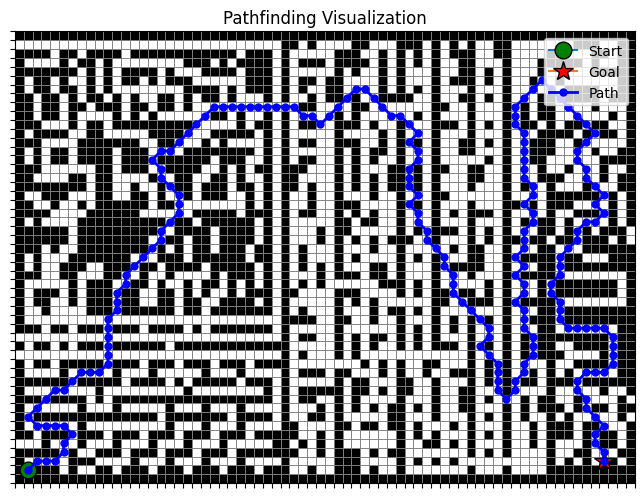

In [8]:
# Import necessary library
import numpy as np

def test_on_more_complex_maze():
    """
    Tests the pathfinding algorithm on a more complex maze and visualizes the result.
    """
    # Define a more complex maze grid
    # 'S' = Start, 'G' = Goal, 1 = Obstacle, 0 = Free space
    grid = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 'S', 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 'G', 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ], dtype=object)
    
    # Initialize variables for start and goal positions
    start_pos = None
    goal_pos = None
    
    # Process the grid to find 'S' and 'G' and convert grid to numerical values
    processed_grid = np.zeros_like(grid, dtype=int)  # Initialize with zeros
    
    for i in range(grid.shape[0]):  # Iterate over rows
        for j in range(grid.shape[1]):  # Iterate over columns
            cell = grid[i][j]
            if cell == 'S':
                start_pos = Point(i, j)
                processed_grid[i][j] = 0  # Start is a free space
            elif cell == 'G':
                goal_pos = Point(i, j)
                processed_grid[i][j] = 0  # Goal is a free space
            elif cell == 1:
                processed_grid[i][j] = 1  # Obstacle
            else:
                processed_grid[i][j] = 0  # Free space
    
    # Validate that start and goal positions were found
    if start_pos is None or goal_pos is None:
        print("Error: Start or Goal position not found in the grid.")
    else:
        # Create the Room object with the processed grid
        room = Room(rows=grid.shape[0], cols=grid.shape[1], start=start_pos, goal=goal_pos)
        room.grid = processed_grid.tolist()  # Convert NumPy array to list of lists
    
        # Parameters for the cost function
        distance_weight = 1.0
        obstacle_weight = 2.0
    
        # Find the best path using the pathfinding algorithm
        path_result = find_best_path(room, distance_weight, obstacle_weight)
        min_cost = path_result.min_cost
        print(f"Minimum cost to reach goal: {min_cost}")
    
        # Reconstruct the path from the parent grid
        path = reconstruct_path(path_result.parent, room.start, room.goal)
    
        # Check if a path was found and visualize
        if min_cost < INF and path:
            print("Path found:")
            for p in path:
                print(f"({p.x}, {p.y})", end=" ")
            print("\n")
            visualize_path(room, path)
        else:
            print("No path exists from start to goal.")

# Execute the test on the more complex maze
test_on_more_complex_maze()
